<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/AI/Mod%C3%A8le000001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fonctions de base

In [0]:

##Python / Colab
from google.colab import files
from google.colab import drive
import os
from IPython.display import Image as imgIPython
from IPython.display import clear_output,display
## Tensorflow keras
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Conv2D,Convolution2D,Activation
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Dropout,Reshape,BatchNormalization
from tensorflow.keras.layers import concatenate,Concatenate,Subtract,Multiply,Average,Add
from tensorflow.keras.layers import UpSampling2D, Reshape,Flatten
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import models
from tensorflow.keras.models import Model
import tensorflow.keras.losses

## Math libraries
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
##Images
from PIL import Image
import cv2
## Graph
from graphviz import render
from graphviz import Digraph,Graph

In [2]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
print("Utilise le",str(device_lib.list_local_devices()[0])[15:18])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TIPE
Utilise le CPU


# Setup input

In [0]:
def create_datasets(train_rate=0.7,validation_rate=0.2,test_rate=0.1):
    images = ["Galaxies_resized/"+f for f in os.listdir("Galaxies_resized/")]
    indexes = np.arange(len(images))
    np.random.shuffle(indexes)
    if os.path.exists("Datasets_list.txt"):
        with open("Datasets_list.txt","r") as file:
            train_dataset = file.readline().strip().split(",")
            validation_dataset = file.readline().strip().split(",")
            test_dataset = file.readline().strip().split(",")
    else:
        train_dataset = [images[i] for i in indexes[:int(train_rate*len(images))+1]]
        validation_dataset = [images[i] for i in indexes[int(train_rate*len(images))+1:int((train_rate+validation_rate)*len(images))+1]]
        test_dataset = [images[i] for i in indexes[int((train_rate+validation_rate)*len(images))+1:]]
        with open("Datasets_list.txt","w") as file:
            file.write(",".join(train_dataset))
            file.write(",".join(validation_dataset))
            file.write(",".join(test_dataset))
    return train_dataset,validation_dataset,test_dataset

In [0]:
def next_batch(batch_size, images,tailleAttendue,formatArray):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    """
    imageEntreeTensor = []
    imageSortieTensor = []
    while len(imageEntreeTensor) < batch_size:
        try:
            np.random.shuffle(images)#choix aléatoire de l'image
            image = cv2.imread(images[0])#Ouvre en rgb l'image nettoyée
            resizedImage = cv2.resize(image,(tailleAttendue,tailleAttendue))
            imageSortieTensor.append(np.array(resizedImage,dtype=formatArray))
            imageEntreeTensor.append(np.array(resizedImage,dtype=formatArray))
        except:
            print("Error in next_batch")
    imageEntreeTensor = np.array(imageEntreeTensor,formatArray)
    return [imageEntreeTensor,imageEntreeTensor]

In [0]:
def next_batch_bruit_voile(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    assert formatArray == np.float32
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageEntreeTensor,imageSortieTensor = imageEntreeTensor/255,imageSortieTensor/255
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy + np.random.normal(bruitParam[0],bruitParam[1],imageSortieTensorCopy.shape),plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def next_batch_bruit_voile_2(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    La versison 2 fait les  modification sélectives de couleurs après avoir ajouté le bruit
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
                   OU liste de liste specifiant la plage de valeurs aléatoire entre lesquelles prendre l'atténuation
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    assert formatArray == np.float32
    assert type(facteursVoile) == list, "Data type required : list not %s"%(type(facteursVoile))
    assert len(facteursVoile) == 3, "Not the correct amount of data : expected 3 'data' (list or floats) in a list not %d"%(len(facteursVoile))
    
    if type(facteursVoile[0]) == list:
        if len(facteursVoile[0]) != 2 or len(facteursVoile[1]) != 2 or len(facteursVoile[2]) != 2:
            print("facteursVoile currently used : ",facteursVoile)
            raise ValueError("Expected each facteursVoile subelement to be 3 lists of 2 elements")
        random_value = np.random.rand(1)*(facteursVoile[0][1]-facteursVoile[0][0])+facteursVoile[0][0]
        for rgbIndex in range(3):
            facteursVoile[rgbIndex] = random_value
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageEntreeTensor,imageSortieTensor = imageEntreeTensor/255,imageSortieTensor/255
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    imageSortieTensorCopy = np.array(imageSortieTensorCopy,dtype=formatArray)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
            imageSortieTensorCopy[image,:,:,rgbIndex] += np.random.normal(bruitParam[0],bruitParam[1])
    imageSortieTensorCopy /= np.max(imageSortieTensorCopy)
    imageSortieTensorCopy *= plageVal[1]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy,plageVal[0],plageVal[1])
    imageEntreeTensor /= np.max(imageEntreeTensor)
    imageEntreeTensor *= plageVal[1]
    imageEntreeTensor = np.clip(imageEntreeTensor,plageVal[0],plageVal[1])
    return [imageEntreeTensor,imageSortieTensorCopy]

In [0]:
def normalisation(arrayL,plageEntree=[0,255],plageSortie=[0,1]):
    assert plageEntree != plageSortie
    assert plageEntree[1]>0 and plageSortie[1] > 0
    formatArray = [array.dtype for array in arrayL]
    L = [np.array(array,dtype=np.float) for array in arrayL]
    for i in range(len(L)):
        L[i] = np.array((L[i]-plageEntree[0])/(plageEntree[1]-plageEntree[0])*(plageSortie[1]-plageSortie[0])+plageSortie[0],formatArray[i])
    return L

# Conversions

In [0]:
def LarrayFloatToUint(L):
    return [np.array(array,np.uint) for array in L]

In [0]:
def convertToUintL(L):
    Lresult = []
    print("Entree : ",len(L))
    for i in range(len(L)):
        Lresult.append(np.array(normalisation(L[i],[0,1],[0,255]),dtype=np.uint8))
    print("Sortie : ",len(Lresult))
    return Lresult

In [0]:
def convertToUint(array):
    return np.array(normalisation(array,[0,1],[0,255]),dtype=np.uint8)

In [0]:
# cf https://stackoverflow.com/questions/43784921/how-to-display-custom-images-in-tensorboard-using-keras?noredirect=1#comment85726690_43784921
def make_image(tensor):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    tensor = np.stack((tensor,tensor,tensor),axis=-1)
    height, width, channel = tensor.shape # numpy.ndarray
    image = Image.fromarray(tensor)
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    CHANNEL = 1
    var = tf.Summary.Image(height=height,
                         width=width,
                         colorspace=CHANNEL,
                         encoded_image_string=image_string)
    print("var : ",var)
    return var

In [0]:
def print_shape(x):
    print("Shape : ",x.get_shape().as_list())

In [0]:
def tauxApprentissage(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def differenceAcceptee(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def save_img(img_array_normalized,path):
    assert type(img_array_normalized) == np.ndarray, "Pass a numpy array"
    assert len(img_array_normalized.shape) == 4, "Pass a tensor, a batch of images with 4 dimensions"
    assert img_array_normalized.shape[-1] == 3, "Pass a tensor with 3 channels at the end to build rgb images"
    assert np.max(img_array_normalized) <=1, "Max tensor value must be 1 no %f"%np.max(img_array_normalized)
    individual_path = path
    for i in range(img_array_normalized.shape[0]):
        individual_path = path + "_batchIndex_%d"%(i)
        cv2.imwrite(path+'.jpg', np.uint8(img_array_normalized[i,:,:,:]*255))

# Couches

In [0]:
# source : https://stackoverflow.com/questions/46418373/how-to-resize-interpolate-a-tensor-in-keras
def interpolation(h,w,inputTensor):
    def resize_like(inputTensor,h,w):
        return tf.image.resize_nearest_neighbor(inputTensor, [h, w])

    return Lambda(resize_like, arguments={'h':h,'w':w})(inputTensor)

## SELU

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Optimizer


# Ported from https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam.py
class RectifiedAdam(Optimizer):
    """RectifiedAdam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        final_lr: float >= 0. Final learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        gamma: float >= 0. Convergence speed of the bound function.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: Weight decay weight.
        amsbound: boolean. Whether to apply the AMSBound variant of this
            algorithm.
    # References
        - [On the Variance of the Adaptive Learning Rate and Beyond]
          (https://arxiv.org/abs/1908.03265)
        - [Adam - A Method for Stochastic Optimization]
          (https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond]
          (https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0.0, **kwargs):
        super(RectifiedAdam, self).__init__(**kwargs)

        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')

        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay

        self.weight_decay = float(weight_decay)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            beta2_t = self.beta_2 ** t
            N_sma_max = 2 / (1 - self.beta_2) - 1
            N_sma = N_sma_max - 2 * t * beta2_t / (1 - beta2_t)

            # apply weight decay
            if self.weight_decay != 0.:
                p_wd = p - self.weight_decay * lr * p
            else:
                p_wd = None

            if p_wd is None:
                p_ = p
            else:
                p_ = p_wd

            def gt_path():
                step_size = lr * K.sqrt(
                    (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max /
                    (N_sma_max - 2)) / (1 - self.beta_1 ** t)

                denom = K.sqrt(v_t) + self.epsilon
                p_t = p_ - step_size * (m_t / denom)

                return p_t

            def lt_path():
                step_size = lr / (1 - self.beta_1 ** t)
                p_t = p_ - step_size * m_t

                return p_t

            p_t = K.switch(N_sma > 5, gt_path, lt_path)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay}
        base_config = super(RectifiedAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
def SELU(x):
    return 1.0507*K.elu(x,alpha=1.67326)

get_custom_objects().update({'custom_activation': Activation(SELU)})

# A mettre pour le modèle : Activation(SELU)

## LRN2D

In [0]:
class LRN2D(Layer):#Normalisation de réponse locale
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)
        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Layers graph mode implementation

### Graph

#### Global managment

In [0]:
def g_get_current_id():
	global index_couches
	return str(index_couches)
def g_get_past_id(back=1):
	global index_couches
	return str(index_couches-back)
def g_new_id():
	global index_couches
	index_couches += 1
	return str(index_couches)
def g_link(graph,id1,id2):
	graph.edge(id1,id2)
index_graph = 0
index_couches = 0
def new_graph(bgcolor='transparent'):
    """Return the graph"""
    global index_graph
    global index_couches
    index_couches = 0
    graph = Digraph(name="cluster_Graph%d"%(index_graph),format='png')
    graph.attr(bgcolor=bgcolor)
    index_graph += 1
    return graph
def end_graph(graph,name):
    """Create the png file of the graph"""
    graph.render(name)
def begin_cluster(past_couche,name,color):
	orig_graph = past_couche[1]
	past_couche[1] = Digraph(name="cluster_%s"%(name))
	past_couche[1].attr(style='filled', color=color, label=name)
	return orig_graph, past_couche
def end_cluster(last_couche,orig_graph):
	orig_graph.subgraph(last_couche[1])
	last_couche[1] = orig_graph
	return last_couche

#### Layers

In [0]:
def g_conv(graph,prev,noyau, filtres, strides = 1, auto_connect = True, identifier=False):
	label = None
	if type(noyau) == int:
		label = "{Convolution | {Noyau | %d} | {Filtres | %d} | {Strides | %d}}"%(noyau,filtres,strides)
	else:
		label = "{Convolution | {Noyau | %dx%d} | {Filtres | %d} | {Strides | %d}}"%(noyau[0],noyau[1],filtres,strides)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		print("Convolution à g_get_current_id %s"%(g_get_current_id()))
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_max_p(graph,prev,noyau, auto_connect = True, identifier=False):
	label = "{MaxPooling | {Noyau | %d}}"%(noyau)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_dense(graph,prev,filtres, strides = 1, auto_connect = True, identifier=False):
	label = "{Dense | {Filtres | %d} | {Strides | %d}}"%(filtres,strides)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())

def g_dropout(graph,prev,taux, auto_connect = True, identifier=False):
	label = ""
	if type(taux) == float:
		label = "{Dropout | {Rate\n(taux désactivation) | %.3f}}"%(taux)
	else:
		label = "{Dropout | {Rate\n(taux désactivation) | Adapté}}"

	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_regLoc(graph,prev,noyau = 20, k = 2, alpha= 10**-4,beta = 0.75, auto_connect = True, identifier=False):
	label = "{Regularisation\nRéponse\nLocale | {Noyau | %d} | {k | %.2f} | {alpha | %.2e} | {beta | %.2e}}"%(noyau,k,alpha,beta)
	if identifier == True:
		print(identifier)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_activation(graph,prev,type = "SELU", auto_connect = True, identifier=False):
	label = "{Activation | {Type | %s}}"%(type)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_batch_norm(graph,prev, auto_connect = True, identifier=False):
	label = "{Normalisation\nPar\nBatch}"
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_flat(graph,prev, auto_connect = True, identifier=False):
	label = "{Flatten}"
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_concat(graph,index, identifier=False):
    graph.node(g_get_current_id(),"Concatenate",fillcolor="white" if identifier==False else "red")
    for id in index:
        graph.edge(id,g_get_current_id())
def g_add(graph,index, identifier=False):
    graph.node(g_get_current_id(),"+",fillcolor="white" if identifier==False else "red")
    for id in index:
        graph.edge(id,g_get_current_id())
def g_subtract(graph,index, identifier=False):
    graph.node(g_get_current_id(),"-",fillcolor="white" if identifier==False else "red")
    for id in index:
        graph.edge(id,g_get_current_id())
def g_proba(graph,prev, auto_connect = True, identifier=False):
	graph.node(g_get_current_id(),"Probabilite",fillcolor="white" if identifier==False else "red")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())

### Graph, Keras

In [0]:
def extract_inpt(inpt):
    inpt,graph,index,improvements = inpt[0],inpt[1],inpt[2],inpt[3]
    return inpt,graph,index,improvements

def g_input(graph, improvements, shape,content_name,draw=True):
    global index_couches
    inpt = Input(shape=shape, name="%d_%s"%(index_couches,content_name))
    if draw == True:
        graph.node(str(index_couches),content_name)
    index_couches += 1
    return [inpt,graph,g_get_past_id(),improvements]
def conv(inpt,k,f,s,operation=False, identifier=False,draw=True,always=False):
    inpt_tmp,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if always == False:
        if improvements != None and improvements == 0 and always == False:
            index_couches += 1
            return [inpt_tmp,graph,index,0]
    else:
        improvements += 1
    
    if operation == True:
        raise Exception("Operation option to check !")
    couche = conv_unit(inpt,k,f,s,operation=operation, identifier=identifier,draw=draw,first=True)
    couche = conv_unit(couche,k,f,s,operation=operation, identifier=identifier,draw=draw,first=False)
    couche,graph,index,improvements = extract_inpt(couche)
    if improvements != None:
        improvements = max(improvements-1,0)
    return [couche,graph,g_get_past_id(),improvements]
    
    
def conv_unit(inpt,k,f,s,operation=False, identifier=False,draw=True,first=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    couche = None
    if first == True:
        couche = Convolution2D(filters=f,kernel_size=(k,1),activation=None,strides=(s,s),padding='SAME',name="%d_conv_k%d_f%d"%(index_couches,k,f),trainable=True)(inpt)
    else:
        couche = Convolution2D(filters=f,kernel_size=(k,1),activation=None,strides=(s,s),padding='SAME',name="%d_conv_k%d_f%d"%(index_couches,k,f),trainable=True)(inpt)
        
    if draw == True:
        if operation == False:
            g_conv(graph,prev=index,noyau=(k,1) if first == True else (1,k),filtres=f,strides=s, identifier=identifier)
        else:
            g_conv(graph,prev=index,noyau=k,filtres=f,strides=s,auto_connect=False, identifier=identifier)
    if identifier == True:
        print("Previous index %s current %s"%(index,g_get_current_id()))
    index_couches += 1
    return [couche,graph,g_get_past_id(),improvements]
def dropout(inpt,r,operation=False, identifier=False,draw=True,always=False):
    name = ""
    global index_couches
    if type(r) != float:
        r = K.cast(r[0,0],K.floatx())
        name = '%d_dropout_r_adaptative'%(index_couches)
    else:
        name = '%d_dropout_r%.2f'%(index_couches,r)
    inpt,graph,index,improvements = extract_inpt(inpt)
    if always == False:
        if improvements != None and improvements == 0:
            index_couches += 1
            return [inpt,graph,index,0]
    else:
        improvements += 1    
    trainable = True if improvements == None or max(improvements-1,0) > 0 else False
    couche = Dropout(name=name,rate=r,trainable=trainable)(inpt)
    if draw == True:
        if operation == False:
            g_dropout(graph,prev=index,taux=r, identifier=identifier)
        else:
            g_dropout(graph,prev=index,taux=r,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def lrn(inpt,n,k,a,b,operation=False, identifier=False,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,index,0]
    couche = LRN2D(name='%d_lrn_n%d_k%d_a%.2e_b%.2f'%(index_couches,n,k,a,b),n=n,k=k,alpha=a,beta=b)(inpt)
    if draw == True:
        if operation == False:
            g_regLoc(graph,prev=index, identifier=identifier)
        else:
            g_regLoc(graph,prev=index,auto_connect=False, identifier=identifier,always=False)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def activ(inpt,act_type,operation=False, identifier=False,draw=True,always=False):
    inpt,graph,index,improvements = extract_inpt(inpt)
    
    global index_couches
    if always == False:
        if improvements != None and improvements == 0:
            index_couches += 1
            return [inpt,graph,index,0]
    else:
        improvements += 1
    assert act_type=="SELU", "other activation functions than SELU are currently not supported"
    couche = Activation(SELU,name='%d_activation_%s'%(index_couches,act_type))(inpt)
    if draw == True:
        if operation == False:
            g_activation(graph,prev=index, identifier=identifier)
        else:
            g_activation(graph,prev=index,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def b_norm(inpt,operation=False, identifier=False,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    print("b_norm improvmts : ",improvements)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,index,0]
    trainable = True if improvements == None or max(improvements-1,0) > 0 else False
    couche = BatchNormalization(name='%d_batchnorm'%(index_couches),trainable=trainable)(inpt)
    if draw == True:
        if operation == False:
            g_batch_norm(graph,prev=index, identifier=identifier)
        else:
            g_batch_norm(graph,prev=index,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def dense(inpt,f,operation=False, identifier=False,draw=True):
    global index_couches
    inpt,graph,index,improvements = extract_inpt(inpt)
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,index,0]
    trainable = True if improvements == None or max(improvements-1,0) > 0 else False
    couche = Dense(f,activation=None,name='%d_dense_f%d'%(index_couches,f),trainable=trainable)(inpt)
    if draw == True:
        if operation == False:
            g_dense(graph,prev=index,filtres=f, identifier=identifier)
        else:
            g_dense(graph,prev=index,filtres=f,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def extract_inpt_L(L):
    L_inpt = [L[i][0] for i in range(len(L))]
    graph = L[0][1]
    ids = [inpt[2] for inpt in L]

    return L_inpt,graph,ids,min([L[i][3] for i in range(len(L))])
def concat(L_inpt,operation=False, identifier=False,draw=True):
    L_inpt,graph,index,improvements = extract_inpt_L(L_inpt)
    improvements += 1
    global index_couches
    couche = Concatenate(axis=-1,name='%d_merge'%(index_couches))(L_inpt)
    if draw == True:
        if operation == False:
            g_concat(graph,index, identifier=identifier)
        else:
            g_concat(graph,index, auto_connect=False, identifier=identifier)

    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def subtract(L_inpt,operation=False, identifier=False):
    L_inpt,graph,index,improvements = extract_inpt_L(L_inpt)
    improvements += 1
    global index_couches
    couche = Subtract(name='%d_subtract'%(index_couches))(L_inpt)
    if draw == True:
        if operation == False:
            g_subtract(graph,index, identifier=identifier)
        else:
            g_subtract(graph,index, auto_connect=False, identifier=identifier)

    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def max_p(inpt,k,operation=False, identifier=False,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,index,0]
    trainable = True if improvements == None or max(improvements-1,0) > 0 else False
    couche = MaxPooling2D(name='%d_max_p_k%d'%(index_couches,k),pool_size=k,padding='VALID',trainable=trainable)(inpt)
    if draw == True:
        if operation == False:
            g_max_p(graph,prev=index,noyau=k, identifier=identifier)
        else:
            g_max_p(graph,prev=index,noyau=k,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def add(L_inpt,operation=False, identifier=False,draw=True):
    global index_couches
    ## Code really strange...
#     if L_inpt[0][0].get_shape().as_list()[-1] != 3:
#         if L_inpt[0][3] != None:
#             L_inpt[0][3] = max(L_inpt[0][3],1)
#         L_inpt[0] = conv(L_inpt[0],k=1,f=3,s=1)
#     if L_inpt[1][0].get_shape().as_list()[-1] != 3:
#         if L_inpt[1][3] != None:
#             L_inpt[1][3] = max(L_inpt[1][3],1)
#         L_inpt[1] = conv(L_inpt[1],k=1,f=3,s=1)
    L_inpt,graph,index,improvements = extract_inpt_L(L_inpt)
    improvements += 1
    couche = Add(name='%d_add'%(index_couches))(L_inpt) 
    if draw == True:
        if operation == False:
            g_add(graph,index,identifier=identifier)
        else:
            g_add(graph,index,auto_connect=False,identifier=identifier)

    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def flat(inpt,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,g_get_past_id(),0]
    couche = Flatten(name='%d_flatten'%(index_couches))(inpt)
    if draw == True:
        g_flat(graph,prev=index)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def proba(inpt,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,g_get_past_id(),0]
    couche = Activation('sigmoid',name='%d_sigmoid_proba'%(index_couches))(inpt)
    if draw == True:
        g_proba(graph,prev=index)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]

In [0]:
def rgb_to_magn_angle(x,draw=True):
    x,graph,index,improvements = x[0],x[1],x[2],x[3]
    x = Lambda(lambda x:K.cast(x,"complex64"))(x)
    x_list_magn = []
    x_list_angle = []
    for i in range(3):
        fft = Lambda(lambda x: tf.fft2d(x[:,:,:,i]), output_shape=(None,199,199))(x)
        x_list_magn.append(Lambda(lambda fft:K.expand_dims(tf.math.abs(fft),axis=-1), output_shape=(None,199,199))(fft))
        x_list_angle.append(Lambda(lambda fft: K.expand_dims(tf.math.angle(fft),axis=-1), output_shape=(None,199,199))(fft))
    magn = Concatenate()(x_list_magn)
    angle = Concatenate()(x_list_angle)
    magn = Lambda(lambda magn: K.cast(magn,dtype=tf.float32), output_shape=(None,199,199))(magn)
    angle = Lambda(lambda angle: K.cast(angle,dtype=tf.float32), output_shape=(None,199,199))(angle)
    if draw == True:
        graph.node(g_get_current_id(),"FFT")
        g_link(graph,index,g_get_current_id())
    global index_couches
    index_couches += 1
    return [magn,graph,g_get_past_id(),improvements],[angle,graph,g_get_past_id(),improvements]
def to_rgb(magn,angle,magn_train,angle_train,draw=True):
    magn,graph,magn_index,improvements = extract_inpt(magn)
    angle,graph,angle_index,improvements = extract_inpt(angle)
    magn = Lambda(lambda magn: K.cast(magn,dtype=tf.complex64))(magn)
    angle = Lambda(lambda angle:K.cast(angle,dtype=tf.complex64))(angle)
    x_list_canal = []
    for i in range(3):
        complx_tensor = Lambda(lambda mang_angle: mang_angle[0][:,:,:,i]*tf.exp(1j*mang_angle[1][:,:,:,i]))([magn,angle])
        ifft = Lambda(tf.ifft2d)(complx_tensor)
        x_list_canal.append(K.expand_dims(ifft,axis=-1))
    images = Concatenate()(x_list_canal)
    images = K.cast(images,dtype=tf.float32)
    if draw == True:
        graph.node(g_get_current_id(),"RGB")
        if magn_train == True:
            g_link(graph,magn_index,g_get_current_id())
        if angle_train == True:
            g_link(graph,angle_index,g_get_current_id())
    global index_couches
    index_couches += 1
    return [images,graph,g_get_past_id(),improvements]

In [0]:
def unit(inpt,k,f,dropout_r=None,activation=False,draw=False,init_index=None):
    if init_index != None:
        global index_couches
        index_couches = init_index
    couche = conv(inpt,k=k,f=f,s=1,draw=draw)
    couche = b_norm(couche,draw=draw,identifier=True)
    couche = lrn(couche,n=21,k=2,a=10**-4,b=0.75,draw=draw)
    if activation == True:
        couche = activ(couche,act_type="SELU",draw=draw)
    if dropout_r != None:
        couche = dropout(couche,r=dropout_r,draw=draw)
    return couche

# Model

## Global model

In [0]:
def inception(inpt,draw=True):
    orig_graph, inpt = begin_cluster(past_couche=inpt,name="Inception%s"%(g_get_current_id()),color='red')
    
    T0 = unit(inpt,k=1,f=100,activation=True,dropout_r=0.5,draw=draw)
    T1 = unit(inpt,k=1,f=100,activation=True,dropout_r=0.5,draw=draw)
    T1 = unit(T1,k=1,f=100,activation=True,dropout_r=0.5,draw=draw)

    couche = concat([T0,T1],draw=draw)
    couche = conv(couche,k=1,f=100,s=1,draw=draw)
    couche = add([couche,inpt],draw=draw)
    end_cluster(last_couche=couche, orig_graph=orig_graph)
    return couche

In [0]:
nb_couches = 3
index_disc = 0
def AI_gen_disc_or_disc_without_input(inpt,dropout_rate=None,part='gen_disc',draw=True):
    global index_couches
    global index_disc
    index_couches = 1
    inpt = Lambda(lambda x:K.cast(x,dtype=tf.float32))(inpt)
    graph = Digraph(name='cluster_Graph', format='png')
    graph.attr(bgcolor='transparent')
    graph.node("0","Image")
    inpt = [inpt,graph,g_get_past_id()]
    if part == 'gen_disc' or part == 'gen':
        gen_graph = Digraph(name="cluster_Generator", node_attr={'style':'filled', 'color':'white'})
        gen_graph.attr(style='filled', color='darkgreen',label="Generator")
        inpt[1] = gen_graph
        with K.name_scope('Generateur_FFT'):
            inpt[1] = Digraph(name="cluster_Analyse_FFT", node_attr={'style':'filled', 'color':'white'})
            inpt[1].attr(style='filled', color='lightgrey', label="Analyse_FFT")
            magn,angle = rgb_to_magn_angle(inpt,draw=draw)
            
            
            magn = analyse(magn,dropout_rate,draw=draw,type_donnee="magn")
            angle = analyse(angle,dropout_rate,draw=draw,type_donnee="angle")

            gen_graph.subgraph(angle[1])
            magn[1] = gen_graph
            angle[1] = gen_graph
            fft_back = to_rgb(magn,angle,draw=draw)
        with K.name_scope('Generateur_image'):
            inpt[1] = Digraph(name="cluster_Analyse_Image", node_attr={'style':'filled', 'color':'white'})
            inpt[1].attr(style='filled', color='blue',label="Analyse_image")
            couche = conv(inpt,k=2,f=200,s=1,draw=draw)
            couche = dropout(couche,r=0.25,draw=draw)
            couche = lrn(couche,n=21,k=2,a=10**-4,b=0.75,draw=draw)
            couche = activ(couche,act_type="SELU",draw=draw)
            couche = conv(couche,k=2,f=100,s=1,draw=draw)
            couche = dropout(couche,r=0.25,draw=draw)
            couche = b_norm(couche,draw=draw)
            couche = activ(couche,act_type="SELU",draw=draw)
            couche = conv(couche,k=2,f=100,s=1,draw=draw)
            couche = dropout(couche,r=0.25,draw=draw)
            couche = b_norm(couche,draw=draw)
            couche = activ(couche,act_type="SELU",draw=draw)
            gen_graph.subgraph(couche[1])
            
            couche[1] = gen_graph
            couche = concat([couche,fft_back],draw=draw)
            couche = conv(couche,k=2,f=100,s=1,draw=draw)
            couche = dropout(couche,r=0.25,draw=draw)
            couche = b_norm(couche,draw=draw)
            couche = activ(couche,act_type="SELU",draw=draw)
            couche = conv(couche,k=2,f=100,s=1,draw=draw)
            couche = dropout(couche,r=0.25,draw=draw)
            couche = b_norm(couche,draw=draw)
            couche = activ(couche,act_type="SELU",draw=draw)
            couche = dense(couche,f=3,draw=draw)
            couche = b_norm(couche,draw=draw)
            couche = activ(couche,act_type="SELU",draw=draw)
            index_disc = index_couches
            if part == 'gen':
                return couche[0]
        graph.subgraph(gen_graph)
    if part == 'gen_disc' or part == 'disc':
        disc_graph = Digraph(name="cluster_Discriminator", node_attr={'style':'filled', 'color':'white'})
        disc_graph.attr(style='filled', color='darkorange1',label="Discriminator")
        with K.name_scope('Discriminateur'):
            index_couches = index_disc
            if part == 'gen_disc':
                couche[1] = disc_graph
                coucheAdaptation = conv(couche,k=2,f=100,s=1,draw=draw)
            else:
                inpt[1] = disc_graph
                coucheAdaptation = conv(inpt,k=2,f=100,s=1,draw=draw)
            image = inception(coucheAdaptation,draw=draw)
            image = lrn(image,n=21,k=2,a=10**-4,b=0.75,draw=draw)
            image = b_norm(image,draw=draw)
            image = activ(image,act_type="SELU",draw=draw)
            image = max_p(image,k=3,draw=draw)
            image = inception(image,draw=draw)
            image = lrn(image,n=21,k=2,a=10**-4,b=0.75,draw=draw)
            image = b_norm(image,draw=draw)
            image = activ(image,act_type="SELU",draw=draw)
            image = max_p(image,k=3,draw=draw)
            image = inception(image,draw=draw)
            image = lrn(image,n=21,k=2,a=10**-4,b=0.75,draw=draw)
            image = b_norm(image,draw=draw)
            image = activ(image,act_type="SELU",draw=draw)
            image = inception(image,draw=draw)
            image = lrn(image,n=21,k=2,a=10**-4,b=0.75,draw=draw)
            image = b_norm(image,draw=draw)
            image = activ(image,act_type="SELU",draw=draw)
            image = max_p(image,k=3,operation=False,draw=draw)
        
            resultatAnalyse = flat(image,draw=draw)
            resultatAnalyse = dropout(resultatAnalyse,r=0.1,draw=draw)
            resultatAnalyse = dense(resultatAnalyse,f=10,draw=draw)
            resultatAnalyse = dropout(resultatAnalyse,r=0.25,draw=draw)
            resultatAnalyse = activ(resultatAnalyse,act_type="SELU",draw=draw)
            resultatAnalyse = dense(resultatAnalyse,f=1,draw=draw)
            probabilite = proba(resultatAnalyse,draw=draw)
        graph.subgraph(probabilite[1])
        end_graph(graph,name="Modele000001")
        return probabilite[0]

In [0]:
def AI():
    inpt = Input(shape = (199, 199, nb_couches),name=str(0)+'_'+'Image')
    inpt_dropout = Input(shape = (1),name=str(0)+'_'+'Dropout_rate')
    probabilite_gen_disc = AI_gen_disc_or_disc_without_input(inpt,inpt_dropout,part='gen_disc',draw=True)
    probabilite_disc = AI_gen_disc_or_disc_without_input(inpt,part='disc',draw=False)
    generated_image = AI_gen_disc_or_disc_without_input(inpt,inpt_dropout,part='gen',draw=False)
    return Model(inputs=[inpt,inpt_dropout],outputs=probabilite_gen_disc),Model(inputs=[inpt,inpt_dropout],outputs=probabilite_disc), Model(inputs=[inpt,inpt_dropout],outputs=generated_image)

In [0]:
def mean_gen_disc_top_27(disc,gen,gen_disc,input_image,desired_image,indexModele):
    path_model = "Models/Modele"+str(indexModele)+"_"
    partial_path_gen_backup = path_model + 'gen' + '_'
    partial_path_gen_disc_backup = path_model + 'gen_disc' + '_'
    partial_path_disc_backup = path_model + 'disc' + '_'

    Lloss = []
    Lloss_gen = []
    Lloss_gen_disc = []
    Lloss_disc = []
    
    try:
        gen.save_weights(partial_path_gen_backup + 'orig.h5')
    except:
        gen.save_weights(partial_path_gen_backup + 'orig.h5')
    try:
        gen_disc.save_weights(partial_path_gen_disc_backup + 'orig.h5')
    except:
        gen_disc.save_weights(partial_path_gen_disc_backup + 'orig.h5')
    try:
        disc.save_weights(partial_path_disc_backup + 'orig.h5')
    except:
        disc.save_weights(partial_path_disc_backup + 'orig.h5')

    for i in range(3):
        gen_backup = partial_path_gen_backup + str(i) + '.h5'
        print("Training "+gen_backup)
        try:
            gen.load_weights(partial_path_gen_backup + 'orig.h5')
        except:
            gen.load_weights(partial_path_gen_backup + 'orig.h5')
        loss = gen.train_on_batch(input_image,desired_image)
        try:
            gen.save_weights(gen_backup)
        except:
            gen.save_weights(gen_backup)
        Lloss.append([gen_backup,loss])
    try:
        gen_disc.save_weights(partial_path_gen_disc_backup + 'orig.h5')
    except:
        gen_disc.save_weights(partial_path_gen_disc_backup + 'orig.h5')
    try:
        disc.save_weights(partial_path_disc_backup + 'orig.h5')
    except:
        disc.save_weights(partial_path_disc_backup + 'orig.h5')
    print("Lloss : ",Lloss)
    desired_probability = [1]*input_image[0].shape[0] # Batch size
    Lloss_gen_disc_tmp = []
    for index_gen_disc,path_loss_backup in enumerate(Lloss):
        try:
            gen.load_weights(path_loss_backup[0])
        except:
            gen.load_weights(path_loss_backup[0])
        for i in range(3):
            gen_disc_backup = partial_path_gen_disc_backup + str(i) + '.h5'
            print("Training "+gen_disc_backup)
            try:
                gen_disc.load_weights(partial_path_gen_disc_backup + 'orig.h5')
            except:
                gen_disc.load_weights(partial_path_gen_disc_backup + 'orig.h5')
            loss = gen_disc.train_on_batch(input_image,desired_probability)
            try:
                gen_disc.save_weights(gen_disc_backup)
            except:
                gen_disc.save_weights(gen_disc_backup)
            Lloss_gen_disc_tmp.append(path_loss_backup + [gen_disc_backup,loss])
    Lloss = Lloss_gen_disc_tmp
    print("Lloss : ",Lloss)

    desired_probability = [1]*(input_image[0].shape[0]//2)+[0]*(input_image[0].shape[0]//2)
    Lloss_disc_tmp = []
    for index_model,item in enumerate(Lloss):
        for i in range(3):
            disc_backup = partial_path_disc_backup + str(i) + '.h5'
            print("Training "+disc_backup)
            try:
                gen_disc.load_weights(Lloss[index_model][-2])
            except:
                gen_disc.load_weights(Lloss[index_model][-2])
            loss = disc.train_on_batch(input_image,desired_probability)
            try:
                disc.save_weights(disc_backup)
            except:
                disc.save_weights(disc_backup)
            Lloss_disc_tmp.append(Lloss[index_model]+[disc_backup,loss])


    Lloss = [Lloss_disc_tmp[i] + [(Lloss_disc_tmp[i][1]+Lloss_disc_tmp[i][3]+Lloss_disc_tmp[i][5])/3] for i in range(len(Lloss_disc_tmp))]
    print("Lloss : ",Lloss)
    Lloss.sort(key=lambda elem:elem[-1])
    print("Lloss sorted : ",Lloss)
    try:
        gen_disc.load_weights(Lloss[0][2])
        disc.load_weights(Lloss[0][-3])
    except:
        gen_disc.load_weights(Lloss[0][2])
        disc.load_weights(Lloss[0][-3])
    print("Best model back")
    return Lloss[0]

In [0]:
def sauvegardeModele(entree_pure,entree_deterioree,model,iteration_entrainement,summary_writer,batch_size=5):
    global Llayers
    for canal_image in range(3):
        summary_image = tf.Summary(value=[tf.Summary.Value(tag="input_pure_canal_"+str(canal_image), 
                                image=make_image(np.array(entree_pure[0][0,:,:,canal_image]*255,dtype=np.uint8)))])
        summary_writer.add_summary(summary_image,iteration_entrainement)
        summary_image = tf.Summary(value=[tf.Summary.Value(tag="input_deterioree_canal_"+str(canal_image), 
                                image=make_image(np.array(entree_deterioree[0][0,:,:,canal_image]*255,dtype=np.uint8)))])
        summary_writer.add_summary(summary_image,iteration_entrainement)
        
    for p,entree in enumerate([entree_pure,entree_deterioree]):
        print("p value %d"%(p))
        layer_outputs,layer_names = [Llayers[i][0] for i in range(len(Llayers))],[Llayers[i][1] for i in range(len(Llayers))]
        model_calcul_image = Model(inputs=model.input,outputs=[model.output]+layer_outputs)
        sorties_couches = model_calcul_image.predict(entree, batch_size=batch_size)[1:] if len(layer_outputs) > 0 else [model_calcul_image.predict(entree, batch_size=batch_size)][1:]
        
        for index_couche,sortie_couche in enumerate(sorties_couches):
            layer_name = layer_names[index_couche]
            dim_sortie = sortie_couche.shape
            if len(dim_sortie) == 4:
                for canal_image in range(dim_sortie[-1]):
                    tag = layer_name
                    tag += 'pure' if p == 0 else 'deterioree'
                    tag += "_canal_" + str(canal_image)
                    summary_image = tf.Summary(value=[tf.Summary.Value(tag=tag, 
                                            image=make_image(np.array(sortie_couche[0,:,:,canal_image]*255,dtype=np.uint8)))])
                    summary_writer.add_summary(summary_image,iteration_entrainement)
    return None

In [0]:
from google.colab import output
def beep():
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
    return None

In [0]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
continuer = None
def block_or_continue():
    beep()
    print("Would you resume training ? True or False ?")
    return bool(input())

In [0]:
def backup(image,imageBruitee,gen_disc,disc,index,summary_writer):
    x = [np.concatenate((image[0],imageBruitee[0])),np.concatenate((image[1],imageBruitee[1]))]
    sauvegardeModele(image,imageBruitee,gen_disc,index,summary_writer)
    p_gen_disc = gen_disc.predict(x)[0]
    p_disc = disc.predict(x)[0]

    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité gen-disc img 0 (orig pure) pure : ", 
                                        simple_value=p_gen_disc) ])
    summary_writer.add_summary(summary_loss,index)
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité disc img 0 (orig pure) pure : ", 
                                        simple_value=p_disc) ])
    summary_writer.add_summary(summary_loss,index)
    x_proba = [np.concatenate((imageBruitee[0],imageBruitee[0])),np.concatenate((imageBruitee[1],imageBruitee[1]))]
    p_gen_disc = gen_disc.predict(x_proba)[0]
    p_disc = disc.predict(x_proba)[0]
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité gen-disc img 0 (orig détériorée) pure : ", 
                                        simple_value=p_gen_disc) ])
    summary_writer.add_summary(summary_loss,index)
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité disc img 0 (orig détériorée) pure : ", 
                                        simple_value=p_disc) ])
    summary_writer.add_summary(summary_loss,index)

In [0]:
def custom_loss(y_true,y_pred):
    return K.mean(K.square(y_pred - y_true),axis=-1)+K.max(K.square(y_pred - y_true),axis=-1)

In [0]:
def to_fft(img_tensor):
    L = []
    print(img_tensor.shape[0],img_tensor.get_shape().as_list())
    for index_image in range(img_tensor.get_shape().as_list()[0]):
        L.append(to_fft_single(img_tensor[index_image,:,:,:]))
    return np.stack(L,axis=0)

def to_img(fft_cplx):
    return to_uint8_array(np.fft.ifft2(fft_cplx))
def to_fft_single(img):
    fft_cplx = np.fft.fft2(img)
    fft = 20*np.log(np.abs(fft_cplx)+10**-5*np.ones(img.shape))
    fft = fft + np.abs(np.min(fft))*np.ones(fft.shape)
    fft = fft / (np.max(fft)*np.ones(fft.shape))*(255*np.ones(fft.shape))
    fft_uint8 = to_uint8_array(fft)
    print(np.max(fft_uint8),np.min(fft_uint8),fft_uint8.shape,fft_uint8.dtype)
    return fft_cplx

def to_uint8_array(array):
    return array.astype(np.uint8)
def next_batch_bruit_voile_fft():
    image,imageBruitee = next_batch_bruit_voile_2(10,images,199,np.float32,[1,1,1],[50,50])
    

## FFT Pretraining

### Model

In [0]:
def analyse_progressive_training_model(couche,step=0,init=2,draw=True):
    print("Couche initiale : ",couche)
    T0 = unit(couche,k=2,f=100,activation=False,dropout_r=0.25,init_index=init,draw=draw)
    global index_couches

    T1 = unit(couche,k=2,f=50,activation=False,dropout_r=0.25,draw=draw)
    T1 = unit(T1,k=2,f=50,activation=False,dropout_r=0.25,draw=draw)
    
    T_straight = dropout(couche,r=0.2,draw=draw)
    couche_concat = concat([T0,T1],draw=draw)
    couche = conv(couche_concat,k=2,f=3,s=1,draw=draw,always=True)
    couche = activ(couche,act_type="SELU",draw=draw,always=True)
    couche = dropout(couche,r=0.4,always=True)
    couche = add([T_straight,couche],draw=draw)
    return  couche


In [0]:
index_couches = -12
def model_fft_training(step,half_batch_size,name,magn_select=True,angle_select=True):#else angle
    global index_disc
    global index_couches
    index_couches = 1
    graph = new_graph()
    inpt = g_input(graph=graph, improvements=step, shape=(199, 199, 3),content_name="Image")
    inpt_real = g_input(graph=graph, improvements=step, shape=(199, 199, 3),content_name="Image_real",draw=False)

    magn,angle = rgb_to_magn_angle(inpt,draw=True)
    r_magn,r_angle = rgb_to_magn_angle(inpt_real,draw=False)

    if magn_select == True:
        magn = analyse_progressive_training_model(magn,step=step,init=2)
    if angle_select == True:
        angle = analyse_progressive_training_model(angle,step=step,init=18)
    
    img_rgb = to_rgb(magn=magn,angle=angle,magn_train=magn_select,angle_train=angle_select) 
    model = Model(inputs=[inpt[0],inpt_real[0]],outputs=img_rgb[0])
    end_graph(img_rgb[1],name=name)
    return model, r_magn[0],r_angle[0], magn[0], angle[0]

Couche initiale :  [<tf.Tensor 'lambda_11/lambda_11/Identity:0' shape=(?, 199, 199, 3) dtype=float32>, <graphviz.dot.Digraph object at 0x7ff15d483748>, '2', 1]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Convolution à g_get_current_id 18
Convolution à g_get_current_id 19
b_norm improvmts :  0
Convolution à g_get_current_id 23
Convolution à g_get_current_id 24
b_norm improvmts :  0
b_norm improvmts :  0
Convolution à g_get_current_id 34
Convolution à g_get_current_id 35
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Is it a correct graph for step 1 angle False et magn True ?
path : Pretrain_test_fft_10_angle_1.png


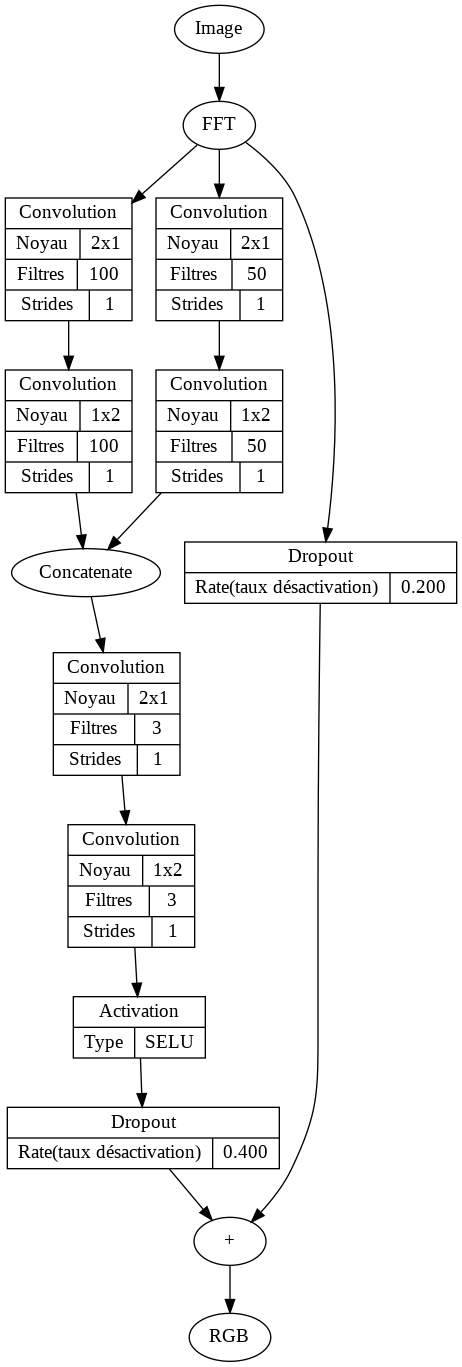

T
Couche initiale :  [<tf.Tensor 'lambda_42/lambda_42/Identity:0' shape=(?, 199, 199, 3) dtype=float32>, <graphviz.dot.Digraph object at 0x7ff133b19f60>, '2', 1]
Convolution à g_get_current_id 2
Convolution à g_get_current_id 3
b_norm improvmts :  0
Convolution à g_get_current_id 7
Convolution à g_get_current_id 8
b_norm improvmts :  0
b_norm improvmts :  0
Convolution à g_get_current_id 18
Convolution à g_get_current_id 19
Is it a correct graph for step 1 angle True et magn False ?
path : Pretrain_test_fft_10_magn_1.png


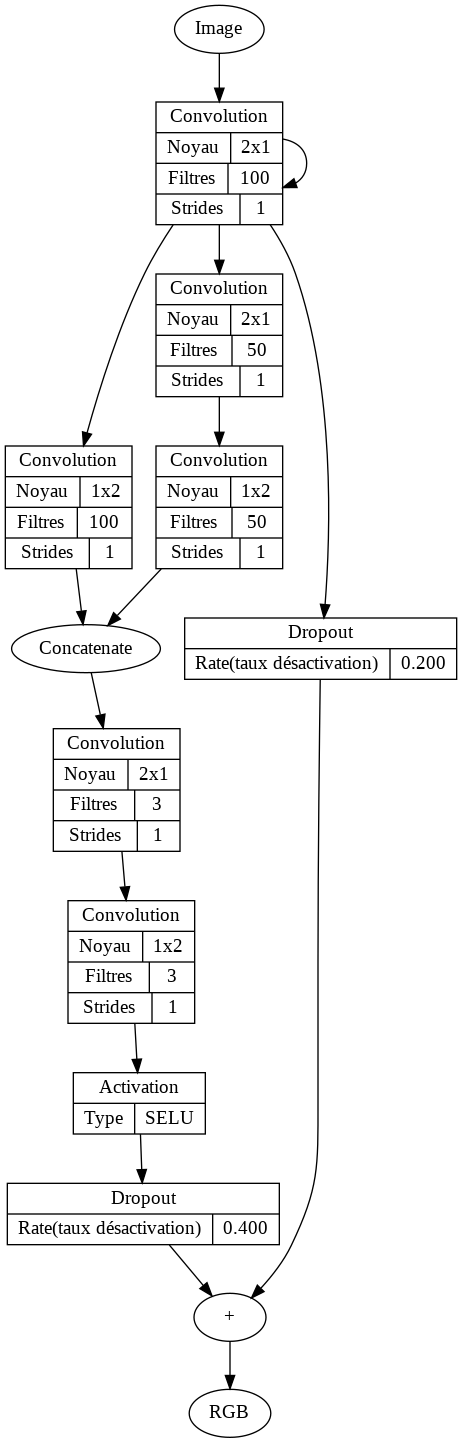

F


Exception: ignored

In [37]:
for step in range(1,10):
    for training_L in [[False,True],[True,False],[True,True]]:
        base_name = "Pretrain_test_fft_%d"%10
        graph_name = base_name
        if training_L[0] == True:
            graph_name += "_magn"
        if training_L[1] == True:
            graph_name += "_angle"
        graph_name = graph_name + "_%d"%(step)
        backup_path = graph_name + ".h5"
        model_fft_training(step,half_batch_size=5,name=graph_name,magn_select=training_L[0],angle_select=training_L[1])
        print("Is it a correct graph for step %d angle %r et magn %r ?"%(step,training_L[0],training_L[1]))
        print("path : %s"%('%s.png'%(graph_name)))
        graph = imgIPython(filename='%s.png'%(graph_name)) 
        display(graph)
        validation = input()
        if validation != "T":
            raise Exception("The graph is not correct")

### Backup

In [0]:
def search_restore_pt(index_model,model,magn_trained,angle_trained,base_name):
    best_angle_training = None
    best_magn_training = None
    max_step_angle = 0
    max_step_magn = 0
    folder = "Model%d/"%index_model
    if os.path.exists(folder) == False:
        print("No restore point found")
        return None
    for file in os.listdir(folder):
        if file.endswith(".h5") and base_name in file:
            # If file is saved with the name Pretrain_fft_index_model_angle_magn_step_it.h5
            if "magn" in file:
#                 step = int(file.split("_")[-2]) # Récupere l'étape d'entrainement du modèle
#                 if step > max_step_magn:
                best_magn_training = folder + file
#                     max_step_magn = step
            if "angle" in file:
#                 step = int(file.split("_")[-2])# Récupere l'étape d'entrainement du modèle
#                 if step > max_step_angle:
                best_angle_training = folder + file
#                     max_step_angle = step
    # Pour cette étape d'entrainement, 
    #       - soit uniquement l'un des deux a été entrainé séparément : cas où à l'iteration step on arrive à magn = True et angle = True 
    #               -> magn déjà entrainé pour step mais angle en est encore à step-1
    #           --> on restaure d'abord le fichier contenant angle et magn de l'étape précédante puis celui d'entrainement particulier
    #           --> soit d'abord dans tous les cas le fichier de angle puis celui de magn
    #       - soit les deux ont été entrainés séparément
    #           --> on restaure les deux fichier sans ordre préférentiel car chaque fichier ne contient pas d'info sur un reseau analysant l'autre partie de l'image
    #       - soit les deux ont été entrainés en commun 
    #           --> on restaure d'abord le fichier contenant angle et magn de l'étape précédante puis celui d'entrainement particulier
    if angle_trained == True and best_angle_training != None:
        model.load_weights(best_angle_training,by_name=True)
    elif angle_trained == True:
        print("No restore point found for angle")
    if magn_trained == True and best_magn_training != None:
        model.load_weights(best_magn_training,by_name=True)
    elif magn_trained == True:
        print("No restore point found for magn")

In [0]:
def backup_fft(num_model,model,image,imageBruitee,graph_name,step,iteration,metrics_list_names,model_state_backup_int=5):
    if os.path.exists("Model%d"%num_model) == False:
        os.mkdir("Model%d"%num_model)
    folder = "Model%d/"%num_model
    metrics_list_values_clean = model.test_on_batch([image,image],image)
    metrics_list_values_noise = model.test_on_batch([imageBruitee,image],image)
    if len(metrics_list_values_clean) != len(metrics_list_names) and len(metrics_list_values_noise) != len(metrics_list_names):
        raise Exception("Metrics names number and model outputs not matching with %d values for model output and %d values for names"%(len(metrics_list_values_clean),len(metrics_list_names)))
    metrics_names = []
    metrics_list_values = []
    for i,name in enumerate(metrics_list_names):
        metrics_names += [name+"_clean",name+"_noise"]
        metrics_list_values += [metrics_list_values_clean[i],metrics_list_values_noise[i]]
    metrics_names = ["Iteration"] + metrics_names
    metrics_list_values = [iteration] + metrics_list_values
    if iteration % model_state_backup_int == 0:
        model.save_weights(folder + graph_name+".h5")
        save_img(image,folder + graph_name+"_%d_img"%iteration)
        save_img(imageBruitee,folder + graph_name+"_%d_img_bruit"%iteration)
        img_gen = model.predict([image,image])
        img_bruit_gen = model.predict([imageBruitee,image])
        save_img(np.clip(img_gen,0,1),folder + graph_name+"_%d_img_gen"%iteration)
        save_img(np.clip(img_bruit_gen,0,1),folder + graph_name+"_%d_img_bruit_gen"%iteration)

    append_write = "w"
    backup_file_path = folder + graph_name+"_step%d_metrics.txt"%step
    if os.path.exists(backup_file_path):
        append_write = 'a' # append if already exists
    with open(backup_file_path,append_write) as file:
        if os.stat(backup_file_path).st_size == 0:
            file.write(",".join(list(map(lambda x:str(x),metrics_names)))+"\n")
        file.write(",".join(list(map(lambda x:str(x),metrics_list_values)))+"\n")
    print("".join([metrics_names[i] + " : " + str(metrics_list_values[i]) + "; " for i in range(len(metrics_list_values))]))


### Loss & Metrics

In [0]:
def fft_loss(r_magn,r_angle, gen_magn,gen_angle):
    def loss(y_true,y_pred):
        return K.mean(K.square(r_magn - gen_magn), axis=-1) + K.mean(K.square(r_angle - gen_angle), axis=-1)
    return loss

In [0]:
Lmetrics = []
Lnames = []
def generate_functions(name,type_data,input_first_function,expression):
    global Lmetrics
    global Lnames
    Lnames.append("%s"%(expression).replace("y","rgb"))
    Lmetrics.append("metrics_%s_%s(%s)"%(type_data,name,",".join(input_first_function)))
    print("def metrics_%s_%s(%s):\n\tdef %s_%s(y_true,y_pred):\n\t\treturn %s\n\treturn %s_%s"%(type_data,name,",".join(input_first_function),type_data,name,expression,type_data,name))
    print()
for minmax in ["min","max"]:
    for magnangle in ["magn","angle"]:
        generate_functions("%s_%s"%(minmax,magnangle),"fft",["r_%s"%(magnangle)],"K.%s(r_%s)"%(minmax,magnangle))
for magnangle in ["magn","angle"]:
    generate_functions("max_abs_diff_%s"%(magnangle),"fft",["r_%s"%(magnangle),"gen_%s"%(magnangle)],"K.max(K.abs(r_%s-gen_%s))"%(magnangle,magnangle))
for magnangle in ["magn","angle"]:
    generate_functions("mean_abs_diff_%s"%(magnangle),"fft",["r_%s"%(magnangle),"gen_%s"%(magnangle)],"K.mean(K.abs(r_%s-gen_%s))"%(magnangle,magnangle))
for magnangle in ["magn","angle"]:
    generate_functions("var_abs_diff_%s"%(magnangle),"fft",["r_%s"%(magnangle),"gen_%s"%(magnangle)],"K.var(K.abs(r_%s-gen_%s))"%(magnangle,magnangle))
generate_functions("max_abs_diff_%s"%(magnangle),"rgb",[],"K.mean(K.abs(y_true-y_pred))")
print("[%s]"%(",".join(Lmetrics)))
print("[%s]"%(",".join(list(map(lambda x:"'"+x+"'",Lnames)))))

In [0]:
def metrics_fft_min_magn(r_magn):
	def fft_min_magn(y_true,y_pred):
		return K.min(r_magn)
	return fft_min_magn

def metrics_fft_min_angle(r_angle):
	def fft_min_angle(y_true,y_pred):
		return K.min(r_angle)
	return fft_min_angle

def metrics_fft_max_magn(r_magn):
	def fft_max_magn(y_true,y_pred):
		return K.max(r_magn)
	return fft_max_magn

def metrics_fft_max_angle(r_angle):
	def fft_max_angle(y_true,y_pred):
		return K.max(r_angle)
	return fft_max_angle

def metrics_fft_max_abs_diff_magn(r_magn,gen_magn):
	def fft_max_abs_diff_magn(y_true,y_pred):
		return K.max(K.abs(r_magn-gen_magn))
	return fft_max_abs_diff_magn

def metrics_fft_max_abs_diff_angle(r_angle,gen_angle):
	def fft_max_abs_diff_angle(y_true,y_pred):
		return K.max(K.abs(r_angle-gen_angle))
	return fft_max_abs_diff_angle

def metrics_fft_mean_abs_diff_magn(r_magn,gen_magn):
	def fft_mean_abs_diff_magn(y_true,y_pred):
		return K.mean(K.abs(r_magn-gen_magn))
	return fft_mean_abs_diff_magn

def metrics_fft_mean_abs_diff_angle(r_angle,gen_angle):
	def fft_mean_abs_diff_angle(y_true,y_pred):
		return K.mean(K.abs(r_angle-gen_angle))
	return fft_mean_abs_diff_angle

def metrics_fft_var_abs_diff_magn(r_magn,gen_magn):
	def fft_var_abs_diff_magn(y_true,y_pred):
		return K.var(K.abs(r_magn-gen_magn))
	return fft_var_abs_diff_magn

def metrics_fft_var_abs_diff_angle(r_angle,gen_angle):
	def fft_var_abs_diff_angle(y_true,y_pred):
		return K.var(K.abs(r_angle-gen_angle))
	return fft_var_abs_diff_angle

def metrics_rgb_max_abs_diff_angle():
	def rgb_max_abs_diff_angle(y_true,y_pred):
		return K.mean(K.abs(y_true-y_pred))
	return rgb_max_abs_diff_angle

### Training

In [0]:
def train_progressive_model(index_model,max_step=200, max_it=1000):
    train_data,validation_data,test_data = create_datasets()
    max_total_it = (max_step-1)*3*max_it
    tot_iteration = 0
    for step in range(1,max_step):
        for index_magn_choice,magn_choice in enumerate([False,True]):
            for index_angle_choice,angle_choice in enumerate([False,True]):
                if magn_choice == False and angle_choice == False:
                    continue

                base_name = "Pretrain_fft_%d"%index_model
                graph_name = base_name
                if magn_choice == True:
                    graph_name += "_magn"
                if angle_choice == True:
                    graph_name += "_angle"
                graph_name = graph_name + "_%d"%(step)
                backup_path = graph_name + ".h5"
                model,r_magn,r_angle, gen_magn,gen_angle = model_fft_training(step=step,half_batch_size=5,name=graph_name,magn_select=magn_choice,angle_select=angle_choice)
                
                metrics_list = [metrics_fft_min_magn(r_magn),metrics_fft_min_angle(r_angle),metrics_fft_max_magn(r_magn),metrics_fft_max_angle(r_angle),metrics_fft_max_abs_diff_magn(r_magn,gen_magn),metrics_fft_max_abs_diff_angle(r_angle,gen_angle),metrics_fft_mean_abs_diff_magn(r_magn,gen_magn),metrics_fft_mean_abs_diff_angle(r_angle,gen_angle),metrics_fft_var_abs_diff_magn(r_magn,gen_magn),metrics_fft_var_abs_diff_angle(r_angle,gen_angle),metrics_rgb_max_abs_diff_angle()]
                metrics_list_names = ["Loss",'K.min(r_magn)','K.min(r_angle)','K.max(r_magn)','K.max(r_angle)','K.max(K.abs(r_magn-gen_magn))','K.max(K.abs(r_angle-gen_angle))','K.mean(K.abs(r_magn-gen_magn))','K.mean(K.abs(r_angle-gen_angle))','K.var(K.abs(r_magn-gen_magn))','K.var(K.abs(r_angle-gen_angle))','K.mean(K.abs(rgb_true-rgb_pred))']
                optimizer = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
                model.compile(loss=fft_loss(r_magn,r_angle, gen_magn,gen_angle),metrics=metrics_list,optimizer="Adam")
                search_restore_pt(index_model,model=model, magn_trained=magn_choice,angle_trained=angle_choice,base_name=base_name)
                for iteration in range(max_it):
                    image,imageBruitee = next_batch_bruit_voile_2(5,train_data,199,np.float32,[[0,1.-iteration/(max_it+1)],[0,1.-iteration/(max_it+1)],[0,1.-iteration/(max_it+1)]],[(iteration//20)/max_it,(iteration//20)/max_it],[0,1])
                    x = np.concatenate((image,imageBruitee),axis=0)
                    y = np.concatenate((image,image),axis=0)
                    metrics_list_values = model.train_on_batch([x,y],y)
                    loss = metrics_list_values[0]
                    backup_fft(index_model,model,image,imageBruitee,graph_name,step,iteration,metrics_list_names,model_state_backup_int=5)
                    whose_is_training = ""
                    if magn_choice == True and angle_choice == True:
                        whose_is_training += "magn et angle" 
                    elif magn_choice == True:
                        whose_is_training += "magn" 
                    elif angle_choice == True:
                        whose_is_training += "angle" 
                    print("Etape d'entrainement %d de %s iteration %d statut %d pourcent, erreur %.5e"%(step,whose_is_training, iteration,tot_iteration/max_total_it,loss))
                    tot_iteration += 1

In [0]:
train_progressive_model(10)

In [0]:
iteration,max_it=1000,1000
train_data,validation_data,test_data = create_datasets()
print([1.-iteration/max_it,1e-5])
print((iteration//20)/max_it)
image,imageBruitee = next_batch_bruit_voile_2(5,train_data,199,np.float32,[[1.-iteration/max_it,1e-5],[1.-iteration/max_it,1e-5],[1.-iteration/max_it,1e-5]],[(iteration//20)/max_it,(iteration//20)/max_it],[0,1])
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Bruitee")
plt.imshow(imageBruitee[0,:,:,:])
plt.subplot(1,2,2)
plt.title("Orig")
plt.imshow(image[0,:,:,:])